# Compute the recovery latency of the system after node failures

In [55]:
import pandas as pd
import numpy as np

pd.set_option("display.precision", 10)
pd.set_option('max_colwidth', 120)

In [56]:
paths =	{
    #"111": "../../logs/failure-recovery/25-03-2021",
    "73": "../../logs/failure-recovery/29-03-2021"
}

exclude_paths = ["broken"]

timeframe_upper_limit = 60 # sec
failure_time = 30

In [57]:
m_stamps = []
m_topologies = []
m_runs = []
m_node_ids = []
m_messages = []
m_unix_stamps = []
m_down_parents = []
m_backups = []
m_startup_times = {}

d_stamps = []
d_topologies = []
d_runs = []
d_node_ids = []
d_sources = []

for path in paths :     
    for root, dirs, files in os.walk(paths[path]) :      
        dirs[:] = [directory for directory in dirs if directory not in exclude_paths]  
        run = root.split('_')[-1]

        for file in files :
            with open( os.path.join(root, file) ) as log :   
                node_id = file.split('_')[0][4:]              
                for line in log :            
                    if "PARENT DOWN" in line: 
                        elem = line.split( )  

                        m_topologies.append(int(path))
                        m_runs.append(int(run))
                        m_node_ids.append(int(node_id))
                        m_stamps.append(int(elem[0]))
                        m_unix_stamps.append(-1)
                        m_down_parents.append(int(elem[13].split(',')[0]))
                        m_backups.append(int(elem[16]))
                    elif "DATA RECEIVED" in line:
                        # data messages
                        elem = line.split( )                

                        d_topologies.append( int(path) )
                        d_runs.append(int(run))
                        d_node_ids.append(int(node_id))                        
                        d_sources.append(int(elem[12]))
                        d_stamps.append(int(elem[8])) # unix timestamp
                    # elif "RECEIVED MESSAGE" in line:
                        # data messages
                    #     elem = line.split( )
 
                    #     topologies.append( int(path) )
                    #     runs.append(int(run))                        
                    #     node_ids.append(int(node_id))                        
                    #     timestamps.append(-1)
                    #     unix_timestamps.append(int(elem[8]) ) # unix timestamp
                    #     messages.append(str(elem[9:]))
                    elif "STARTUP TIME" in line:
                        elem = line.split( )
                        m_startup_times[(int(run), int(node_id))] = int(elem[-1])


m_data = pd.DataFrame(np.column_stack([m_topologies, m_runs, m_node_ids, m_stamps, m_down_parents, m_backups]),
                        columns=['topology', 'run', 'node_id', 'timestamp', 'down_parent', 'backup'])

d_data = pd.DataFrame(np.column_stack([d_topologies, d_runs, d_node_ids, d_sources, d_stamps]), 
                        columns=['topology', 'run', 'node_id', 'message_source', 'timestamp'])

In [58]:
m_data

,topology,run,node_id,timestamp,down_parent,backup
0,73,1,30,30311,37,64
1,73,1,38,30257,37,64
2,73,1,26,69673,1,28
3,73,1,68,30060,37,10
4,73,1,60,30113,37,10
5,73,1,71,96281,28,19
6,73,1,42,30232,37,64
7,73,1,70,30047,37,10
8,73,1,51,30172,37,64
9,73,1,33,30292,37,64


In [59]:
m_data['timestamp'] = m_data['timestamp'] / 1000
m_data = m_data[(m_data['timestamp'] < timeframe_upper_limit) & (m_data['timestamp'] > failure_time - 5)].reset_index()
m_data.head()

,index,topology,run,node_id,timestamp,down_parent,backup
0,0,73,1,30,30.311,37,64
1,1,73,1,38,30.257,37,64
2,3,73,1,68,30.060,37,10
3,4,73,1,60,30.113,37,10
4,6,73,1,42,30.232,37,64


In [60]:
d_data['timestamp'] = d_data.apply(lambda row: (row.timestamp - m_startup_times[(row.run, row.node_id)]) / 1000000000, axis=1)
d_data = d_data[(d_data['timestamp'] > failure_time - 5)]
d_data.head()

,topology,run,node_id,message_source,timestamp
150,73,1,55,48,25.160564649
151,73,1,55,52,25.160937155
152,73,1,55,49,25.161413106
153,73,1,55,52,25.661018967
154,73,1,55,48,25.661294896


In [61]:
d_data['timestamp'].max()

59.977677925

# Find the reconnection timestamp for each node that lost its parent

In [62]:

tmp = m_data.merge(d_data, how='left',
                    left_on=['topology', 'run', 'backup', 'node_id'],
                    right_on=['topology', 'run', 'node_id', 'message_source'])
tmp.rename(columns={'timestamp_x': 'down_time', 'timestamp_y': 'first_tuple_time'}, inplace=True)
tmp.drop(columns=['node_id_y', 'message_source'], inplace=True)
tmp


,index,topology,run,node_id_x,down_time,down_parent,backup,first_tuple_time
0,0,73,1,30,30.311,37,64,30.098732010
1,0,73,1,30,30.311,37,64,30.598640470
2,0,73,1,30,30.311,37,64,31.098815182
3,0,73,1,30,30.311,37,64,31.598898414
4,0,73,1,30,30.311,37,64,32.099357267
...,...,...,...,...,...,...,...,...
381,27,73,2,16,30.387,10,10,NaN
382,28,73,2,13,30.404,10,10,NaN
383,29,73,2,18,30.372,10,10,NaN
384,30,73,2,12,30.409,10,10,NaN


In [65]:
aggs = {'down_time': 'first', 'first_tuple_time': 'min', 'down_parent': 'first', 'backup':'first'}

res = tmp.groupby(['topology', 'run', 'node_id_x'], as_index=False).agg(aggs)
res['Recovery latencies in [s], n=3'] = res.apply(lambda row: row['first_tuple_time'] - row['down_time'], axis=1)

res

,topology,run,node_id_x,down_time,first_tuple_time,down_parent,backup,"Recovery latencies in [s], n=3"
0,73,0,15,30.419,46.225689945,1,46,15.806689945
1,73,0,21,30.378,30.102283405,1,64,-0.275716595
2,73,0,32,30.309,48.112518384,1,64,17.803518384
3,73,0,57,30.143,NaN,1,64,NaN
4,73,0,59,30.130,NaN,1,64,NaN
5,73,1,2,30.487,NaN,37,10,NaN
6,73,1,5,30.471,NaN,37,10,NaN
7,73,1,30,30.311,30.098732010,37,64,-0.212267990
8,73,1,33,30.292,30.098534622,37,64,-0.193465378
9,73,1,38,30.257,NaN,37,64,NaN


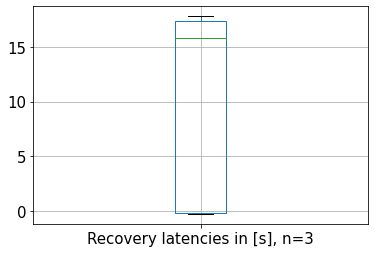

In [66]:
_, bp = res.boxplot(column=['Recovery latencies in [s], n=3'], fontsize=15, return_type='both')